## Data exploration and Random Forest Classifier for hit and run accidentes in Mexico City

Data ranges for accidentes during 2018 - 2019

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [2]:
data_raw = pd.read_csv('df_long_anual_2018.csv')

Data set exploration

In [3]:
data_raw.columns

Index(['...1', 'esq_id', 'año', 'int_seg', 'avenida', 'clave_esq', 'via_1',
       'via_2', 'cantidad_AGEB', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB',
       'area', 'perimeter', 'cod_ageb', 'pob_tot', 'pob_15_64', 'PEA',
       'p_ocup', 'p_desocup', 't_desocup', 'rez_soc', 'n_rez_soc', 'esc_prom',
       'no_atr', 'sum_lesi', 'sum_occi', 'sum_afec', 'luz_sol', 'alcaldia',
       'colonia', 'tipo_int', 'prioridad', 'num_prior'],
      dtype='object')

In [4]:
data_raw.alcaldia.value_counts()

CUAUHTEMOC             596
IZTAPALAPA             426
GUSTAVO A MADERO       385
MIGUEL HIDALGO         277
BENITO JUAREZ          258
COYOACAN               252
ALVARO OBREGON         224
VENUSTIANO CARRANZA    192
IZTACALCO              176
XOCHIMILCO             149
AZCAPOTZALCO           147
TLALPAN                146
TLAHUAC                 77
MAGDALENA CONTRERAS     54
CUAJIMALPA              46
MILPA ALTA              16
Name: alcaldia, dtype: int64

In [5]:
data_raw.isnull().sum()

...1                 0
esq_id               0
año                  0
int_seg              0
avenida              0
clave_esq            0
via_1               17
via_2               29
cantidad_AGEB        0
CVE_ENT             15
CVE_MUN             15
CVE_LOC             15
CVE_AGEB            15
area                15
perimeter           15
cod_ageb            15
pob_tot             15
pob_15_64           15
PEA                 26
p_ocup              26
p_desocup          333
t_desocup           15
rez_soc             84
n_rez_soc           84
esc_prom            15
no_atr               0
sum_lesi             0
sum_occi             0
sum_afec             0
luz_sol          86471
alcaldia         86469
colonia          86469
tipo_int         86469
prioridad        86469
num_prior        86469
dtype: int64

Since we're doing a data set exploration for hit n runs, we're dropping columns and adjusting data that is not revelant to the current analysis.

In [6]:
rem = ['prioridad','num_prior','colonia','luz_sol','esq_id','cantidad_AGEB','CVE_ENT','CVE_MUN','CVE_LOC','CVE_AGEB','area','via_1','via_2','int_seg','año','clave_esq','...1','rez_soc','perimeter','cod_ageb','p_desocup'
,'t_desocup','pob_15_64','alcaldia','tipo_int']

In [7]:
data_raw_clean = data_raw.drop(columns = rem)

We define an ocupation rate, it'll be important for our classification model, but in short, t_ocup is a variable that represents the number of people with jobs over an echonomical active population.

In [8]:
data_raw_clean['t_ocup'] = data_raw_clean.p_ocup / data_raw_clean.PEA

In [9]:
data_raw_clean.drop(columns=['sum_afec','PEA','p_ocup','pob_tot'], inplace=True)

In [10]:
data_raw_clean.no_atr.value_counts()

0     86469
1      2768
2       452
3       120
4        47
5        13
6        10
10        3
8         3
7         3
11        1
9         1
Name: no_atr, dtype: int64

In [11]:
data_target = data_raw_clean[data_raw_clean['no_atr']<=6]

In [12]:
data_raw_clean = data_raw_clean[(data_raw_clean['no_atr'] <= 6) & (data_raw_clean['no_atr'] > 0)]

In [13]:
data_raw_clean.shape

(3410, 7)

Null analyisis and fill

In [14]:
data_raw_clean.isnull().sum()

avenida      0
n_rez_soc    4
esc_prom     0
no_atr       0
sum_lesi     0
sum_occi     0
t_ocup       5
dtype: int64

In [15]:
data_raw_clean.n_rez_soc.fillna(data_raw_clean.n_rez_soc.mean(),inplace=True)

In [16]:
data_raw_clean.isnull().sum()

avenida      0
n_rez_soc    0
esc_prom     0
no_atr       0
sum_lesi     0
sum_occi     0
t_ocup       5
dtype: int64

In [17]:
data_raw_clean.t_ocup.fillna(data_raw_clean.t_ocup.mean(),inplace=True)

In [18]:
data_raw_clean = data_raw_clean.reset_index(drop = True)

In [19]:
data_raw_clean

,avenida,n_rez_soc,esc_prom,no_atr,sum_lesi,sum_occi,t_ocup
0,1,1.0,9.2800,3,3,0,0.951491
1,1,1.0,9.8960,2,2,0,0.960632
2,1,1.0,11.4725,3,3,0,0.957820
3,1,1.0,10.2450,2,3,0,0.950019
4,1,1.0,12.6400,6,6,0,0.967009
...,...,...,...,...,...,...,...
3405,0,1.0,11.1850,1,1,0,0.960730
3406,0,1.0,11.1900,1,1,0,0.942857
3407,0,1.0,9.0600,1,1,0,0.899654
3408,1,1.0,10.0300,1,1,0,0.941124


Data scaling and dropping of columns that won't be necessary for evaluating the model

In [32]:
data_raw_clean_model1 = data_raw_clean.drop(columns=['sum_occi','sum_lesi','no_atr'])

In [33]:
scaler = StandardScaler()

In [34]:
momo = scaler.fit(data_raw_clean_model1)

In [35]:
data_scaled = momo.transform(data_raw_clean_model1)

In [36]:
df_data_scaled = pd.DataFrame(data_raw_clean_model1)
df_data_scaled

,avenida,n_rez_soc,esc_prom,t_ocup
0,1,1.0,9.2800,0.951491
1,1,1.0,9.8960,0.960632
2,1,1.0,11.4725,0.957820
3,1,1.0,10.2450,0.950019
4,1,1.0,12.6400,0.967009
...,...,...,...,...
3405,0,1.0,11.1850,0.960730
3406,0,1.0,11.1900,0.942857
3407,0,1.0,9.0600,0.899654
3408,1,1.0,10.0300,0.941124


Beggining training test split for Random Forest

In [48]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(data_scaled,data_raw_clean.no_atr, random_state = 42, test_size=0.20)

In [44]:
over = SMOTE()

In [45]:
X_train1, Y_train1 = over.fit_resample(X_train1, Y_train1)

Key part of the code: searching for optimal hyperparameters with RandomizedSearchCV

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix 
from sklearn.model_selection import RandomizedSearchCV

model=RandomForestClassifier()
distributions = dict(n_estimators = list(range(100,1001,100)),
                     max_depth = list(range(10,200,10))),
best_params = RandomizedSearchCV(model,distributions,random_state=0)
params = best_params.fit(X_train1,Y_train1)
print(params.best_params_)

{'n_estimators': 800, 'max_depth': 10}


Accuracy score : 0.84
Recall score : 0.71


c:\Users\fhernandezcortez\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


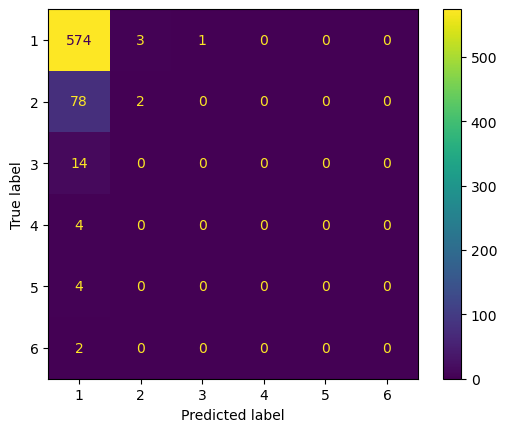

In [50]:
model=RandomForestClassifier(n_estimators=params.best_params_['n_estimators'],max_depth=params.best_params_['max_depth'])
model.fit(X_train1,Y_train1)
YPred1 = model.predict(X_test1)
print("Accuracy score : {:.2f}".format(accuracy_score(YPred1,Y_test1)))
print("Recall score : {:.2f}".format(recall_score(YPred1,Y_test1,average='macro',zero_division=True)))
disp = plot_confusion_matrix(model,X_test1,Y_test1)
plt.show()

<AxesSubplot:>

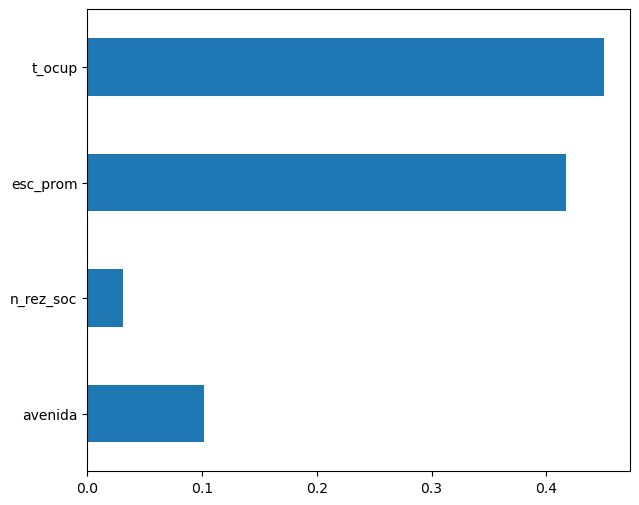

In [52]:
feature_importances = pd.Series(model.feature_importances_, index= data_raw_clean_model1.columns)
feature_importances.sort_values(ascending = True)
feature_importances.plot(kind = 'barh', figsize =(7,6))

In [63]:
data_raw_clean_model1.t_ocup.min()

0.8553054662379421

Feature importances and export into CSV for data showing in Tableu

In [60]:
feature_importances.to_csv('feature_importances.csv')

In [58]:
print("Avenida : {:.2f}".format(feature_importances[0]))
print("Rezagues social : {:.2f}".format(feature_importances[1]))
print("Escolaridad promedio : {:.2f}".format(feature_importances[2]))
print("Tasa de ocupacion : {:.2f}".format(feature_importances[-1]))

Avenida : 0.10
Rezagues social : 0.03
Escolaridad promedio : 0.42
Tasa de ocupacion : 0.45
